In [2]:
!ls

Basics.ipynb  chinook.db  chinook-unmodified.db


In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [5]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [6]:
def show_tables():
    q = '''SELECT name, type 
           FROM sqlite_master 
           WHERE type IN ("table","view");'''
    return run_query(q)

In [7]:
show_tables()

name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table

# Sales by Genre

In [8]:
q = '''
select 
    g.name, 
    count(invoice_line_id) count,
    count(invoice_line_id)/(select cast(count(*) as float) from invoice_line) pct
from invoice_line il
inner join track t on t.track_id = il.track_id
inner join genre g on g.genre_id = t.genre_id
group by g.name
order by count desc
'''
genre_sales = run_query(q)
genre_sales

name  count       pct
0                 Rock   2635  0.553921
1                Metal    619  0.130124
2   Alternative & Punk    492  0.103427
3                Latin    167  0.035106
4             R&B/Soul    159  0.033424
5                Blues    124  0.026067
6                 Jazz    121  0.025436
7          Alternative    117  0.024595
8       Easy Listening     74  0.015556
9                  Pop     63  0.013244
10   Electronica/Dance     55  0.011562
11           Classical     47  0.009880
12              Reggae     35  0.007358
13         Hip Hop/Rap     33  0.006937
14         Heavy Metal      8  0.001682
15          Soundtrack      5  0.001051
16            TV Shows      2  0.000420
17               Drama      1  0.000210

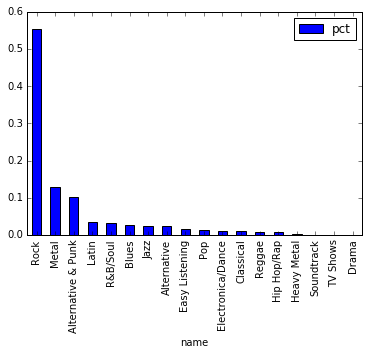

In [9]:
genre_sales.set_index('name').plot.bar(y='pct')

Hip Hop/Rap is the lowest selling genre of the four offered artists (hip-hop, punk, pop, blues) so we should not sell that album. Instead we should sell the other three. 

# Sales Support Agent Analysis

In [10]:
q = '''
select *
from employee
limit 10
'''
emp = run_query(q)
emp

employee_id last_name first_name                title  reports_to  \
0            1     Adams     Andrew      General Manager         NaN   
1            2   Edwards      Nancy        Sales Manager         1.0   
2            3   Peacock       Jane  Sales Support Agent         2.0   
3            4      Park   Margaret  Sales Support Agent         2.0   
4            5   Johnson      Steve  Sales Support Agent         2.0   
5            6  Mitchell    Michael           IT Manager         1.0   
6            7      King     Robert             IT Staff         6.0   
7            8  Callahan      Laura             IT Staff         6.0   

             birthdate            hire_date                      address  \
0  1962-02-18 00:00:00  2016-08-14 00:00:00          11120 Jasper Ave NW   
1  1958-12-08 00:00:00  2016-05-01 00:00:00                 825 8 Ave SW   
2  1973-08-29 00:00:00  2017-04-01 00:00:00                1111 6 Ave SW   
3  1947-09-19 00:00:00  2017-05-03 00:00:00             683 10 Street SW   
4  1965-03-03 00:00:00  2017-10-17 00:00:00                 7727B 41 Ave   
5  1973-07-01 00:00:00  2016-10-17 00:00:00         5827 Bowness Road NW   
6  1970-05-29 00:00:00  2017-01-02 00:00:00  590 Columbia Boulevard West   
7  1968-01-09 00:00:00  2017-03-04 00:00:00                  923 7 ST NW   

         city state country postal_code              phone                fax  \
0    Edmonton    AB  Canada     T5K 2N1  +1 (780) 428-9482  +1 (780) 428-3457   
1     Calgary    AB  Canada     T2P 2T3  +1 (403) 262-3443  +1 (403) 262-3322   
2     Calgary    AB  Canada     T2P 5M5  +1 (403) 262-3443  +1 (403) 262-6712   
3     Calgary    AB  Canada     T2P 5G3  +1 (403) 263-4423  +1 (403) 263-4289   
4     Calgary    AB  Canada     T3B 1Y7   1 (780) 836-9987   1 (780) 836-9543   
5     Calgary    AB  Canada     T3B 0C5  +1 (403) 246-9887  +1 (403) 246-9899   
6  Lethbridge    AB  Canada     T1K 5N8  +1 (403) 456-9986  +1 (403) 456-8485   
7  Lethbridge    AB  Canada     T1H 1Y8  +1 (403) 467-3351  +1 (403) 467-8772   

                      email  
0    andrew@chinookcorp.com  
1     nancy@chinookcorp.com  
2      jane@chinookcorp.com  
3  margaret@chinookcorp.com  
4     steve@chinookcorp.com  
5   michael@chinookcorp.com  
6    robert@chinookcorp.com  
7     laura@chinookcorp.com

In [11]:
q = '''
select 
    e.first_name||" "||e.last_name emp_name,
    e.hire_date,
    sum(i.total) total_sales
from employee e
inner join customer c on c.support_rep_id = e.employee_id
inner join invoice i on i.customer_id = c.customer_id
group by emp_name
'''
sales_agents = run_query(q)
sales_agents

emp_name            hire_date  total_sales
0   Jane Peacock  2017-04-01 00:00:00      1731.51
1  Margaret Park  2017-05-03 00:00:00      1584.00
2  Steve Johnson  2017-10-17 00:00:00      1393.92

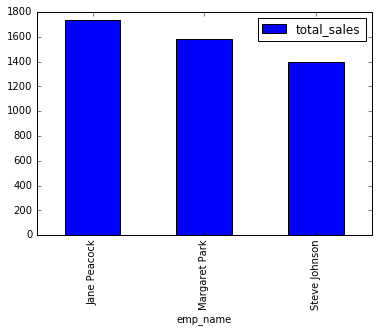

In [12]:
sales_agents.set_index('emp_name').plot.bar()

Total sales of each employee corresponds pretty directly with their hire date. This makes sense because agents who have been at the company longer would make more sales naturally. It would be interesting to compair each agent's sales per day.

In [13]:
sales_agents['hire_date'] = pd.to_datetime(sales_agents['hire_date'],infer_datetime_format=True)

#sales_agents['sales/day'] = sales_agents['total_sales']/

In [14]:
type(sales_agents['hire_date'][0])

pandas.tslib.Timestamp

In [15]:
import datetime
sales_agents['days_employed'] = datetime.date(year=2018,month=3,day=5) - sales_agents['hire_date']

In [29]:
sales_agents['sales($)/day'] = sales_agents['total_sales']/sales_agents['days_employed'].dt.days
sales_agents

emp_name  hire_date  total_sales  days_employed  sales/day  \
0   Jane Peacock 2017-04-01      1731.51       338 days   5.122811   
1  Margaret Park 2017-05-03      1584.00       306 days   5.176471   
2  Steve Johnson 2017-10-17      1393.92       139 days  10.028201   

   dollars/day  sales($)/day  
0     5.122811      5.122811  
1     5.176471      5.176471  
2    10.028201     10.028201

In [34]:
sales_agents.drop('dollars/day',axis=1,inplace=True)

In [35]:
sales_agents

emp_name  hire_date  total_sales  days_employed  sales($)/day
0   Jane Peacock 2017-04-01      1731.51       338 days      5.122811
1  Margaret Park 2017-05-03      1584.00       306 days      5.176471
2  Steve Johnson 2017-10-17      1393.92       139 days     10.028201

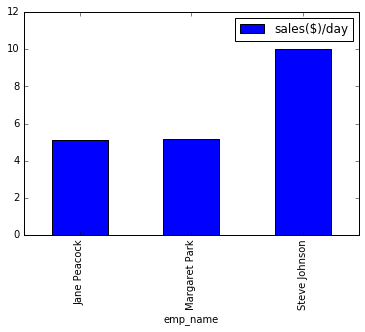

In [36]:
sales_agents.set_index('emp_name').plot.bar(y='sales($)/day')

So we see Steve Johnson is the most productive sales agent the company has even though he has the lowest total sales. His sales per day is nearly the same as Jane Peakock's and Margaret Park's combined!

# Customers by Country

In [76]:
q = '''
with a as (
    select 
        case
            when(
                select count(*)
                from customer
                where country = c.country
            ) = 1
            then "Other"
            else c.country
        end as country,
        c.customer_id,
        i.*
    from customer c
    inner join invoice i on i.customer_id = c.customer_id
)

select
    country,
    count(distinct customer_id) num_customers,
    sum(total) total_sales,
    sum(total)/count(distinct customer_id) avg_customer_value,
    avg(total) avg_order_value
from a
group by country
order by total_sales desc
'''
countries = run_query(q)
countries

country  num_customers  total_sales  avg_customer_value  \
0           Other             15      1094.94           72.996000   
1             USA             13      1040.49           80.037692   
2          Canada              8       535.59           66.948750   
3          Brazil              5       427.68           85.536000   
4          France              5       389.07           77.814000   
5         Germany              4       334.62           83.655000   
6  Czech Republic              2       273.24          136.620000   
7  United Kingdom              3       245.52           81.840000   
8        Portugal              2       185.13           92.565000   
9           India              2       183.15           91.575000   

   avg_order_value  
0         7.448571  
1         7.942672  
2         7.047237  
3         7.011148  
4         7.781400  
5         8.161463  
6         9.108000  
7         8.768571  
8         6.383793  
9         8.721429

In [77]:
countries.loc[10] = countries.loc[0]
countries.drop(0)

country  num_customers  total_sales  avg_customer_value  \
1              USA             13      1040.49           80.037692   
2           Canada              8       535.59           66.948750   
3           Brazil              5       427.68           85.536000   
4           France              5       389.07           77.814000   
5          Germany              4       334.62           83.655000   
6   Czech Republic              2       273.24          136.620000   
7   United Kingdom              3       245.52           81.840000   
8         Portugal              2       185.13           92.565000   
9            India              2       183.15           91.575000   
10           Other             15      1094.94           72.996000   

    avg_order_value  
1          7.942672  
2          7.047237  
3          7.011148  
4          7.781400  
5          8.161463  
6          9.108000  
7          8.768571  
8          6.383793  
9          8.721429  
10         7.448571

In [79]:
countries.reset_index(drop=True)

country  num_customers  total_sales  avg_customer_value  \
0            Other             15      1094.94           72.996000   
1              USA             13      1040.49           80.037692   
2           Canada              8       535.59           66.948750   
3           Brazil              5       427.68           85.536000   
4           France              5       389.07           77.814000   
5          Germany              4       334.62           83.655000   
6   Czech Republic              2       273.24          136.620000   
7   United Kingdom              3       245.52           81.840000   
8         Portugal              2       185.13           92.565000   
9            India              2       183.15           91.575000   
10           Other             15      1094.94           72.996000   

    avg_order_value  
0          7.448571  
1          7.942672  
2          7.047237  
3          7.011148  
4          7.781400  
5          8.161463  
6          9.108000  
7          8.768571  
8          6.383793  
9          8.721429  
10         7.448571

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f01ff6a7cc0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f01ff559b38>]], dtype=object)

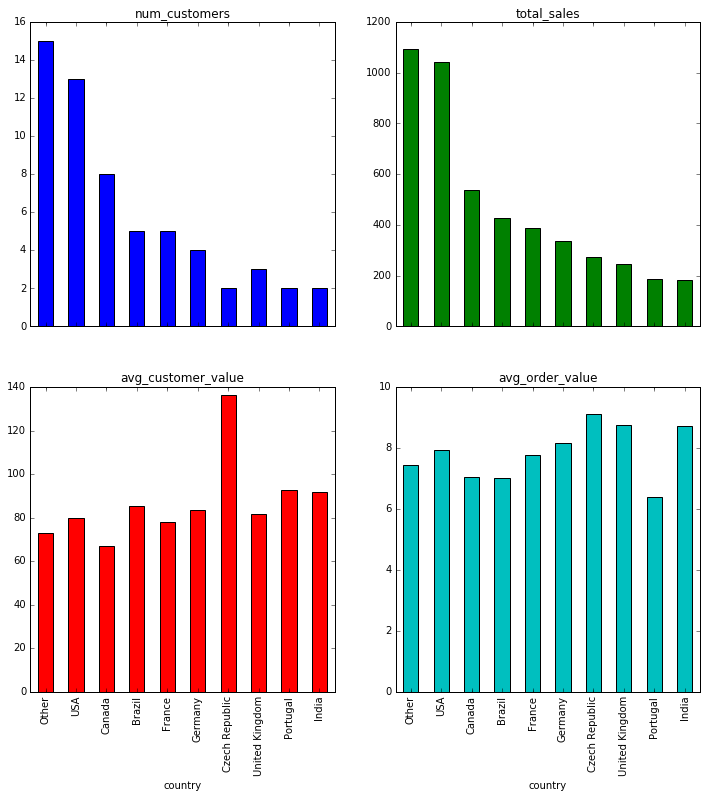

In [111]:
countries[:-1].set_index('country').plot(kind='bar',subplots=True,layout=(2,2),legend=False,figsize=(12,12))

There is potential in the Czech Republic as this country has by far the greatest average customer value. Keep in mind, however, that there are currently only two customers in the Czech Republic. This is not a large enough sample size to tell if this trend will continue. It would be helpful to have more data when finding patterns of these kinds. I need to learn some statistics to help back this up...

In [118]:
#q = '''
#with a as (
#select track_id
#from track
#group by album_id),
#b as (
#select track_id
#from invoice_line
#group by invoice_id
#)
#
#select
#    il.*,
#    case
#        when a except b.track_id is null 
#        and b.track_id except a.track_id is null then "yes"
#        else "no"
#    end as "albool"
#from invoice_line il
#inner join track t on t.track_id = il.track_id
#limit 10
#'''
#albums = run_query(q)
#albums
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

album_purchase  number_of_invoices   percent
0             no                 500  0.814332
1            yes                 114  0.185668

Album purchase invoices are less than 19% of total invoices so we should probably hold on to them I would imagine or a